# **Projet 8 : Assurez une veille technique (Proof Of Concept)**

### **Les librairies nécessaires**

In [ ]:
# Librairie de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
import plotly.express as px
import seaborn as sns


# Traitement de textes
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
from tqdm import tqdm

# Clustering et réduction de dimmensions
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity


# Traitement des images
from keras.applications import inception_v3, InceptionV3
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from PIL import Image, ImageOps

# Apprentissage supervisé
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#### **Dossier de travail**

In [ ]:
# Connecter à googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Choisir le répertoire
dir = os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Projet_OPC/P6_Classification_automatiquement_des_biens/data')

### **Dataset retenu**

In [ ]:
# Charger mon jeu de données
data = pd.read_csv('data_propre.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [ ]:
data[['Categ_A', 'sentence_lem']].head()

,Categ_A,sentence_lem
0,Home Furnishing,elegance polyester multicolor abstract eyelet ...
1,Baby Care,sathiyas cotton bath towel bath towel red yell...
2,Baby Care,eurospa cotton terry face towel set size small...
3,Home Furnishing,santosh royal fashion cotton printed king size...
4,Home Furnishing,jaipur print cotton floral king sized double b...


#### **Fonctions de traitement de textes**

In [ ]:
# Liste des mots très courants en anglais
nltk.download('stopwords')
# WordNet, une grande base de données lexicale de l'anglais.
# Nous allons l'utilise plus loin dans notre code pour l'analyse sémantique et la lemmatisation.
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def display_tokens_info(tokens):
    """display token info"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:20])


####################################################################################
# Tokenizer
def tokenizer_fct(sentence):
    # print(sentence)
    tokenizer = RegexpTokenizer(r"[a-zA-Z]+")
    word_tokens = tokenizer.tokenize(sentence)
    return word_tokens


####################################################################################
# Stop words
stop_w = list(set(stopwords.words('english')))

def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

####################################################################################
# Transformer les mots miniscule et alpha
def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words]
    return lw

####################################################################################
# Lemmatizer (la racine d'un mot)
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# stemmatsation
def stemma_fct(list_words):
    stemmer = PorterStemmer()
    stem_w = [stemmer.stem(w) for w in list_words]
    return stem_w

####################################################################################
def lst_non_informative(corpus,
                        stem_or_lem='lem',
                        thres_com=10):
    """basic function of text processing"""
    corpus_raw = "".join(corpus.values)
    word_tokens = tokenizer_fct(corpus_raw)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)

    if stem_or_lem == 'lem':
        trans = lemma_fct(sw)
    else:
        trans = stemma_fct(sw)

    # unique word
    tmp = pd.Series(trans).value_counts()
    list_unique_words = tmp[tmp == 1].reset_index()
    # common words
    list_common_words = tmp.head(thres_com).reset_index()
    # non informative words
    non_informative_words = pd.concat(
        [list_common_words['index'], list_unique_words['index']], ignore_index=True).to_list()

    return non_informative_words


####################################################################################
def no_info_word_filter_fct(list_words, non_info_word):
    filtered_w = [w for w in list_words if not w in non_info_word]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

####################################################################################

# Fonction de préparation du texte pour le bag of words avec lemm ou stemming
def transform_bow_fct(desc_text, non_info_word, stem_or_lem='lem', rejoin=True):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)

    if stem_or_lem == 'lem':
        st_lem_w = lemma_fct(sw)
    else:
        st_lem_w = stemma_fct(sw)

    filt = no_info_word_filter_fct(st_lem_w, non_info_word)

    if rejoin:
        return " ".join(filt)

    return filt

#### **Fonction de réduction de dimmensions et de clustering**

In [ ]:
def select_n_components(features, goal_var: float) -> int:

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components

####################################################################################
# Calcul Reduction, détermination des clusters et calcul ARI entre vrais catégorie et nbre de clusters
def reduction_fct(features, reduc='SVD'):
    """ Cette fonction permet de réduire et clusteriser des données
    avec le choix de l'algorithme de réduction dans les arguments : SVD ou TSNE
    """

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")

####################################################################################
def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


####################################################################################
def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show();

#### **Outils de comparaison**

In [ ]:
# Initialisation d'une liste vide pour les résultats du clustering (modèle, reduction, ARI) :
ARI_results = np.empty(shape=[0, 3])

####**Filtrage des mots non informatifs**

In [ ]:
lst_stop_word_manual_lem = ['r', 'key', 'product', 'feature', 'color', "type",'specification', 'material', 'general',
                            'sale', 'number', 'warranty', 'detail','quality', 'inch', 'brand']

# Le value counts du corpus nettoyer indique que les 13 premeirs mots ne sont pas informatifs
# (de "product" à "com") -> thres_com = 13
non_informative_words_lem = lst_non_informative(
    data['description'], thres_com=13) + lst_stop_word_manual_lem

data['sentence_lem'] = data['description'].apply(
    lambda x: transform_bow_fct(x, non_informative_words_lem, stem_or_lem='lem'))

### **Word Embedding avec BERT**

###### **Fonction de création des features**

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """ Cette fonction permet de préparer les phrases afin d'appliquer le modèle d'embedding BERT"""

    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf",
                                              verbose=False)

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot

#####################################################################################################
# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    """ Cette fonction permet de préparer les phrases afin d'appliquer le modèle d'embedding BERT"""

    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in tqdm(range(len(sentences)//batch_size)):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                               bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred, verbose=False)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

###### **Entrainement du modèle**

In [ ]:
from transformers import TFAutoModel, TFBertModel, AutoTokenizer

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data['sentence_lem'].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###### **BERT avec Hugging Face**

In [ ]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

100%|██████████| 105/105 [04:58<00:00,  2.85s/it]

temps traitement :  299.0


In [ ]:
features_bert.shape

(1050, 768)

In [ ]:
embeddings_bert = np.array(features_bert)
embeddings_bert.shape

(1050, 768)

######**Redimmension et viz**

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.2969


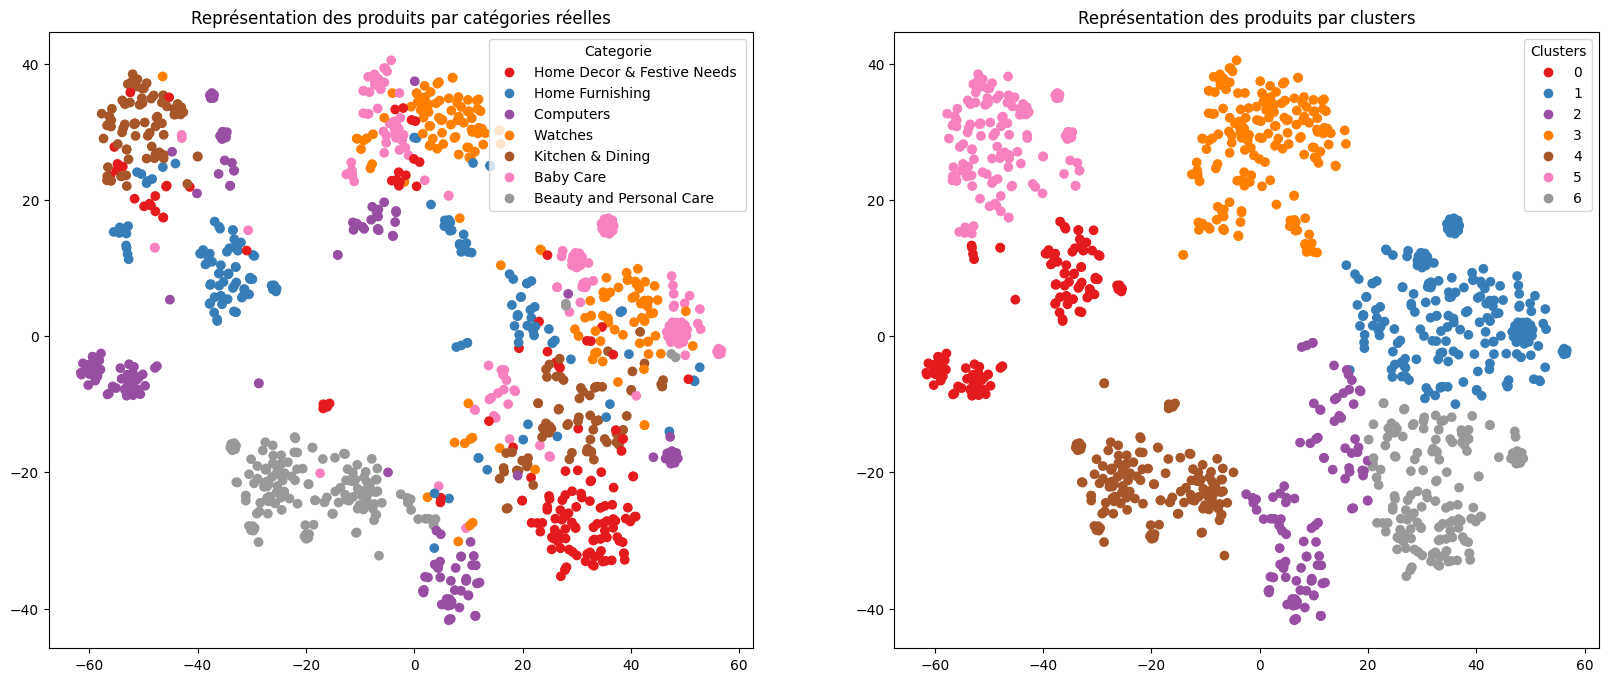

In [ ]:
# t-SNE
X_reduc = reduction_fct(features_bert, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["BERT", "TSNE", ARI]], axis=0)

#### **Features importances**

In [ ]:
# Initialisation de l'encodeur
label_encoder = LabelEncoder()

# Encodage des labels
y_encoded = label_encoder.fit_transform(data['Categ_A'])

# Vérification de l'encodage
print(label_encoder.classes_)  # Affiche les classes encodées

['Baby Care ' 'Beauty and Personal Care ' 'Computers '
 'Home Decor & Festive Needs ' 'Home Furnishing ' 'Kitchen & Dining '
 'Watches ']


##### **Classification**

In [ ]:
X_bert = embeddings_bert
y = data['Categ_A']

# Division des données en train_set et test_set
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y, test_size=0.2, random_state=42)

# Entraînement du modèle de classification (RandomForest)
classifier1 = RandomForestClassifier(n_estimators=100, random_state=42)
classifier1.fit(X_train_bert, y_train_bert)

# Prédiction sur l'ensemble de test
y_pred_bert = classifier1.predict(X_test_bert)

# Évaluation des performances du modèle
print("Rapport de classification :")
print(metrics.classification_report(y_test_bert, y_pred_bert))
print(f"Précision globale : {round(metrics.accuracy_score(y_test_bert, y_pred_bert),2)}")

Rapport de classification :
                             precision    recall  f1-score   support

                 Baby Care        0.75      0.67      0.71        27
  Beauty and Personal Care        0.80      0.95      0.87        21
                 Computers        0.94      0.87      0.90        38
Home Decor & Festive Needs        0.82      0.93      0.88        30
           Home Furnishing        0.83      0.86      0.85        35
          Kitchen & Dining        0.90      0.73      0.81        26
                   Watches        0.94      1.00      0.97        33

                   accuracy                           0.86       210
                  macro avg       0.86      0.86      0.85       210
               weighted avg       0.86      0.86      0.86       210

Précision globale : 0.86


##### **Matrice de confution BERT**

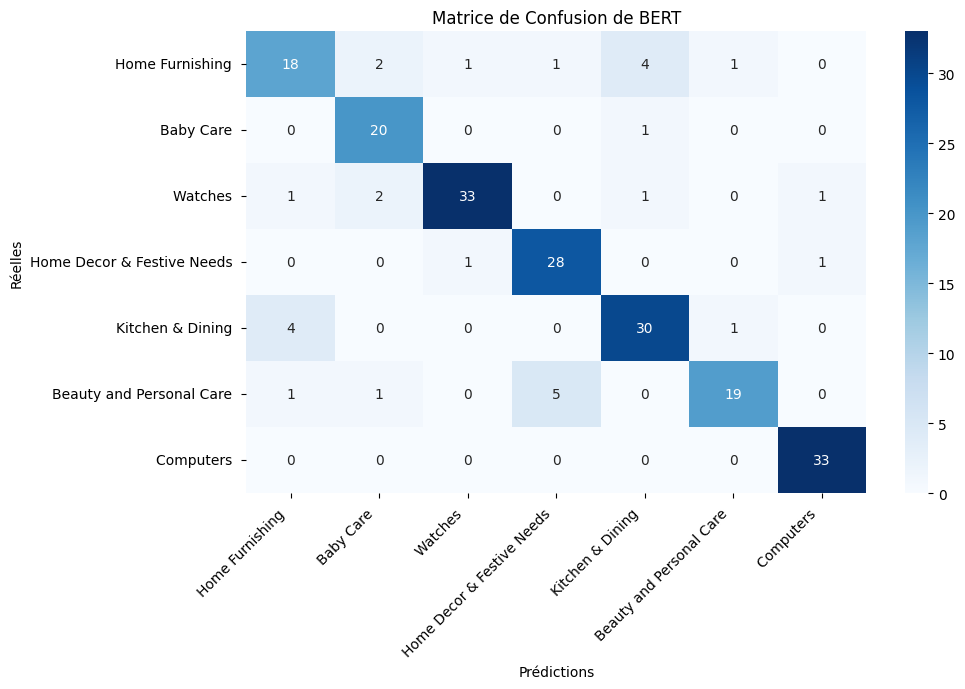

In [ ]:
# Matrice de confusion
categories = data['Categ_A'].unique()
cm_bert = metrics.confusion_matrix(y_test_bert, y_pred_bert)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.xticks(rotation=45, ha='right')
plt.title("Matrice de Confusion de BERT")
plt.show();

##### **Importance globale**

In [ ]:
# Calculer les valeurs SHAP pour l'importance des features globales
import shap
explainer = shap.TreeExplainer(classifier1)
shap_values = explainer.shap_values(X_train_bert)


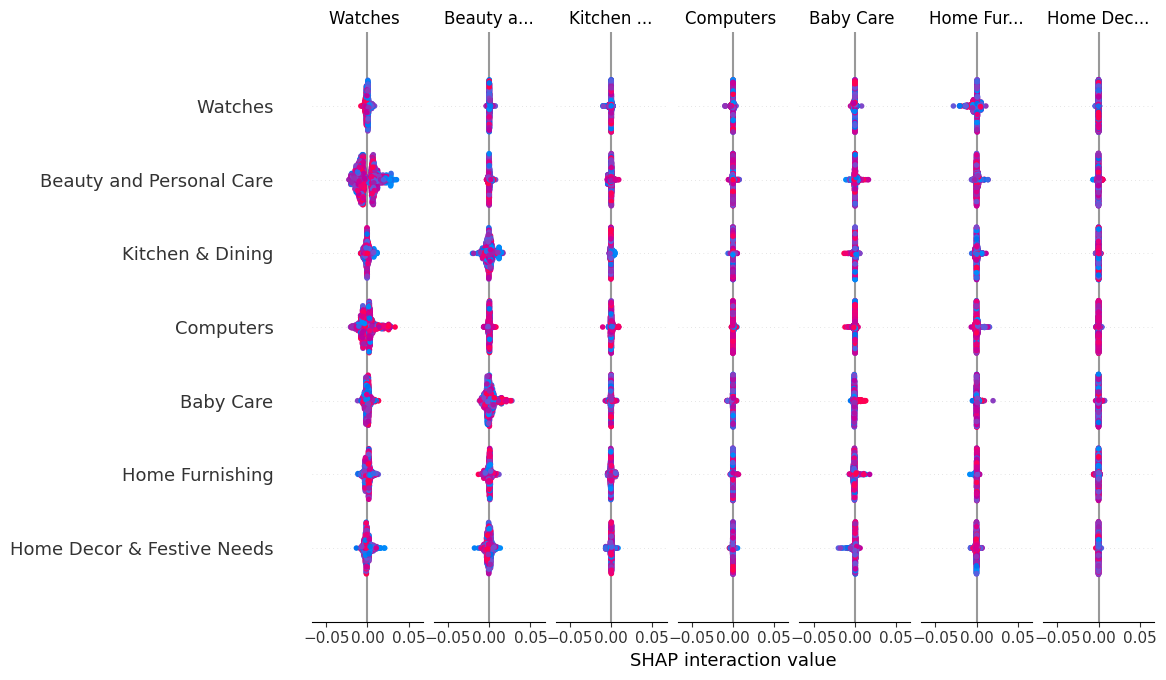

In [ ]:
# Récupérer les vrais noms des features
feature_names = label_encoder.classes_
# shap.summary_plot(shap_values, X_train_m, feature_names=feature_names)
shap.summary_plot(shap_values, X_train_bert
                  , feature_names=feature_names, plot_type="bar")

**Une matrice de features importances** est attendue avec SHAP **pour les modèles multi-classes**.
Cette matrice représente l'importance de chaque feature pour chaque classe et pour chaque instance.

shap.summary_plot nous permet de visualiser cette importance de manière globale ou par classe.

Valeurs SHAP pour chaque classe:

- SHAP calcule l'importance de chaque feature pour chaque classe du modèle.

- **les shap_values** sont en **matrice 3D**, où:
  - La première dimension représente les instances du dataset.
  - La deuxième dimension représente les features.
  - La troisième dimension représente les classes de votre modèle.

Avec **shap.summary_plot** multi-classes, SHAP a automatiquement :

  - Moyenner les valeurs SHAP sur toutes les classes: Pour obtenir une importance globale de chaque feature, SHAP fait la moyenne des valeurs SHAP absolues sur toutes les classes.

**Les 10 features les plus importantes**

In [ ]:
# Calculer les features importantes globalement
importances = classifier1.feature_importances_

# Créer un DataFrame pour mieux visualiser les importances
feature_importances = pd.DataFrame({'feature': range(X_train_bert.shape[1])
, 'importance': importances}).sort_values(by='importance', ascending=False)

# Afficher les 10 features les plus importantes
feature_importances = feature_importances.head(10)

# Visualiser les importances avec un graphique à barres
plt.figure(figsize=(10, 6))
fig_global = px.bar(feature_importances, x='feature', y='importance'
                    , title="Caractéristiques ayant pesé sur le modèle")
fig_global.update_layout(xaxis_title="Importance", yaxis_title="Caractéristiques")
fig_global.show();

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Visualisation de l'importance globale des features
# shap.summary_plot(shap_values, X_train_m)

## **Word Embedding avec ModernBERT**

#### **Chargement du modèle**

In [ ]:
# Installer la dernière version de transformers
# !pip install git+https://github.com/huggingface/transformers.git

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

# Spécifiez le modèle ModernBERT
model_name = "answerdotai/ModernBERT-base"

# Chargez le tokenizer et le modèle
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Désactiver le calcul des gradients pour économiser de la mémoire
model.eval()

# Chargement des données
sentences = data['sentence_lem'].tolist()

#### **Tokenisation et génération des embeddings**

In [ ]:
# Tokenisation et génération des embeddings
def modernbert_embeddings(sentences, model, tokenizer, max_length=64):
    encoded_inputs = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(
            input_ids=encoded_inputs['input_ids'],
            attention_mask=encoded_inputs['attention_mask']
        )

    # Moyenne des embeddings sur la séquence
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings.numpy()

#### **Extraction des embeddings pour toutes les phrases**

In [ ]:
# Extraction des embeddings pour toutes les phrases
embeddings_modernbert = modernbert_embeddings(sentences, model, tokenizer)

In [ ]:
# Conversion en numpy array
embeddings_modernbert = np.array(embeddings_modernbert)
print(embeddings_modernbert.shape)
print("✅ Embeddings générés avec ModernBERT.")

(1050, 768)
✅ Embeddings générés avec ModernBERT.


In [ ]:
# embeddings_np = pd.DataFrame(embeddings_modernbert)
# embeddings_np.head(3)

numpy.ndarray

#### **Réduction de dimension avec t-SNE**

In [ ]:
# from sklearn.manifold import TSNE

# Réduction de dimension avec t-SNE
def fct_reduction(embeddings, reduc='TSNE', n_components=2, random_state=42):
    if reduc == 'TSNE':
        reducer = TSNE(n_components=n_components, random_state=random_state)
    else:
        raise ValueError("Réduction non supportée")

    X_reduc = reducer.fit_transform(embeddings)
    return X_reduc


In [ ]:
# Application de t-SNE
X_reduc_TSNE = fct_reduction(embeddings_modernbert, reduc='TSNE')

print("✅ Réduction de dimension effectuée avec t-SNE.")

✅ Réduction de dimension effectuée avec t-SNE.


#### **Clustering avec K-Means et calcul de l'ARI**

Nous allons maintenant appliquer K-Means sur les données réduites avec t-SNE, puis comparer les clusters obtenus avec les catégories réelles grâce à l'Adjusted Rand Index (**ARI**).

In [ ]:
# Fonction de clustering K-Means et calcul de l'ARI
def fct_kmeans(X, true_labels, n_clusters=None):
    if n_clusters is None:
        n_clusters = len(set(true_labels))  # Nombre de clusters basé sur les catégories réelles

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    predicted_labels = kmeans.fit_predict(X)

    ari_score = adjusted_rand_score(true_labels, predicted_labels)

    return ari_score, predicted_labels


In [ ]:
# Exécution de K-Means et calcul de l'ARI
ARI, labels = fct_kmeans(X_reduc_TSNE, data['Categ_A'])
ARI_results = np.append(ARI_results, [["ModernBERT", "TSNE", ARI]], axis=0)
print(f"✅ Clustering effectué. ARI = {ARI:.4f}")

✅ Clustering effectué. ARI = 0.0735


#### **Visualisation des clusters**

In [ ]:
def visualisation(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show();

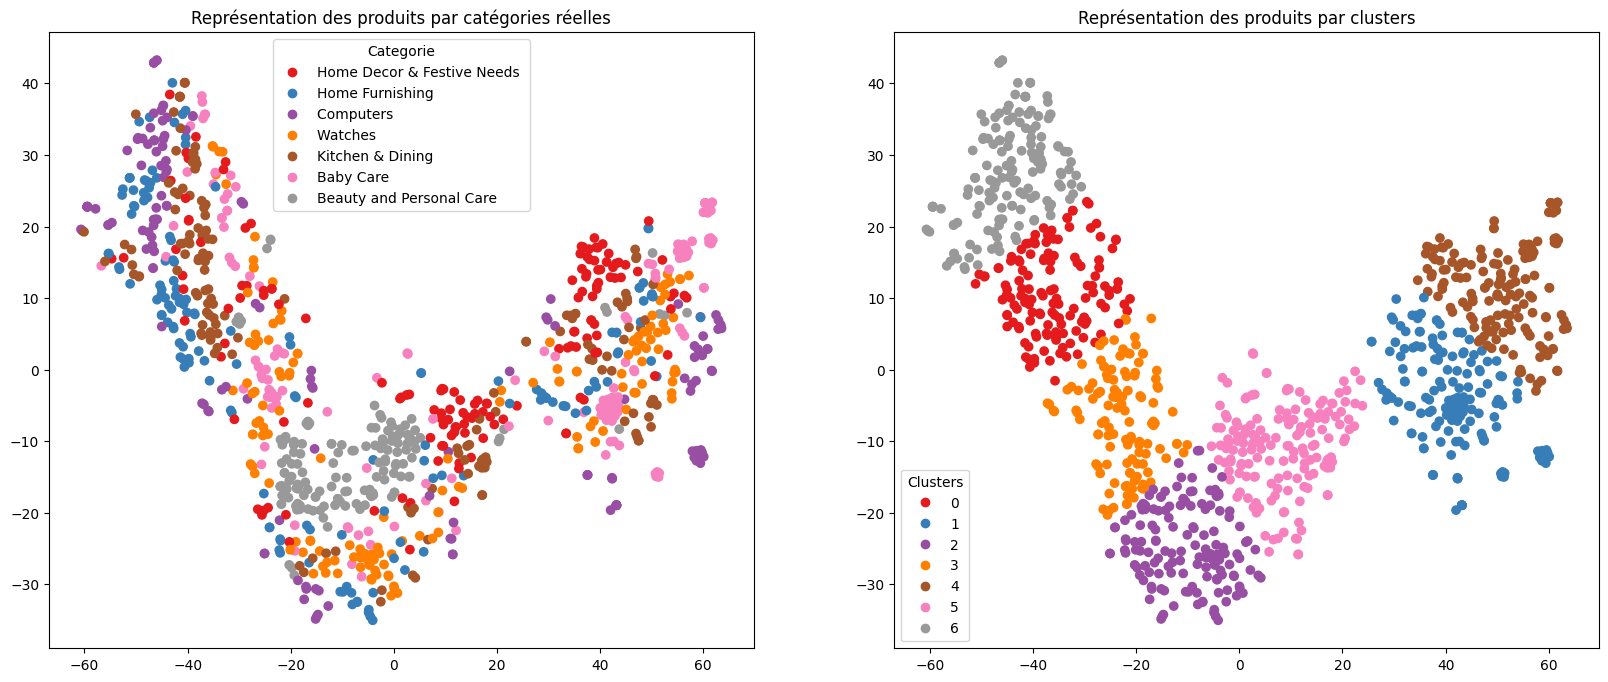

✅ Visualisation des clusters réalisée.


In [ ]:
# Visualisation des clusters
visualisation(X_reduc_TSNE, data['Categ_A'], labels)
print("✅ Visualisation des clusters réalisée.")

### **Features importances**

Pour obtenir des importances globales dans le cadre de clustering ou de classification, une méthode courante est d'utiliser le **RandomForestClassifier**. Ces modèles peuvent vous donner une estimation de l'importance de chaque dimension dans la prise de décision. Cependant, comme les embeddings ModernBERT sont des vecteurs de hautes dimensions (qui ne sont pas interprétables de manière directe comme des features classiques), l'interprétation via des modèles comme SHAP ou LIME est souvent plus appropriée.

#### **Encodage des labels catégoriels avec LabelEncoder**

In [ ]:
# Initialisation de l'encodeur
label_encoder = LabelEncoder()

# Encodage des labels
y_encoded = label_encoder.fit_transform(data['Categ_A'])

# Vérification de l'encodage
print(label_encoder.classes_)  # Affiche les classes encodées


['Baby Care ' 'Beauty and Personal Care ' 'Computers '
 'Home Decor & Festive Needs ' 'Home Furnishing ' 'Kitchen & Dining '
 'Watches ']


#### **Entrainement de ModernBERT**

In [ ]:
X_m = embeddings_modernbert
y = data['Categ_A']

# Division des données en train_set et test_set
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y, test_size=0.2, random_state=42)

# Entraînement du modèle de classification (RandomForest)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_m, y_train_m)

# Prédiction sur l'ensemble de test
y_pred_m = classifier.predict(X_test_m)

# Évaluation des performances du modèle
print("Rapport de classification :")
print(metrics.classification_report(y_test_m, y_pred_m))
print(f"Précision globale : {round(metrics.accuracy_score(y_test_m, y_pred_m),2)}")

Rapport de classification :
                             precision    recall  f1-score   support

                 Baby Care        0.47      0.56      0.51        27
  Beauty and Personal Care        0.83      0.71      0.77        21
                 Computers        0.89      0.89      0.89        38
Home Decor & Festive Needs        0.66      0.77      0.71        30
           Home Furnishing        0.81      0.71      0.76        35
          Kitchen & Dining        0.67      0.62      0.64        26
                   Watches        1.00      0.97      0.98        33

                   accuracy                           0.76       210
                  macro avg       0.76      0.75      0.75       210
               weighted avg       0.77      0.76      0.77       210

Précision globale : 0.76


#### **Matrice de confusion**

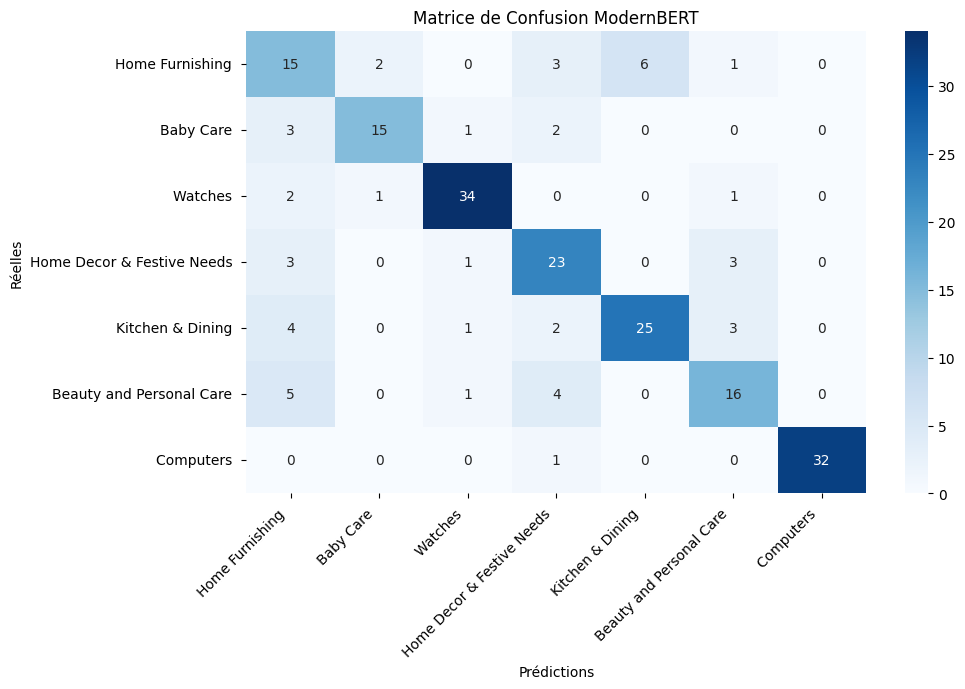

In [ ]:
# Matrice de confusion
categories = data['Categ_A'].unique()
cm_mbert = metrics.confusion_matrix(y_test_m, y_pred_m)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_mbert, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.xticks(rotation=45, ha='right')
plt.title("Matrice de Confusion ModernBERT")
plt.show();

#### **Importance global**

In [ ]:
# Calculer les valeurs SHAP pour l'importance des features globales
import shap
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train_m)


In [ ]:
# Visualisation de l'importance globale des features
# shap.summary_plot(shap_values, X_train_m)

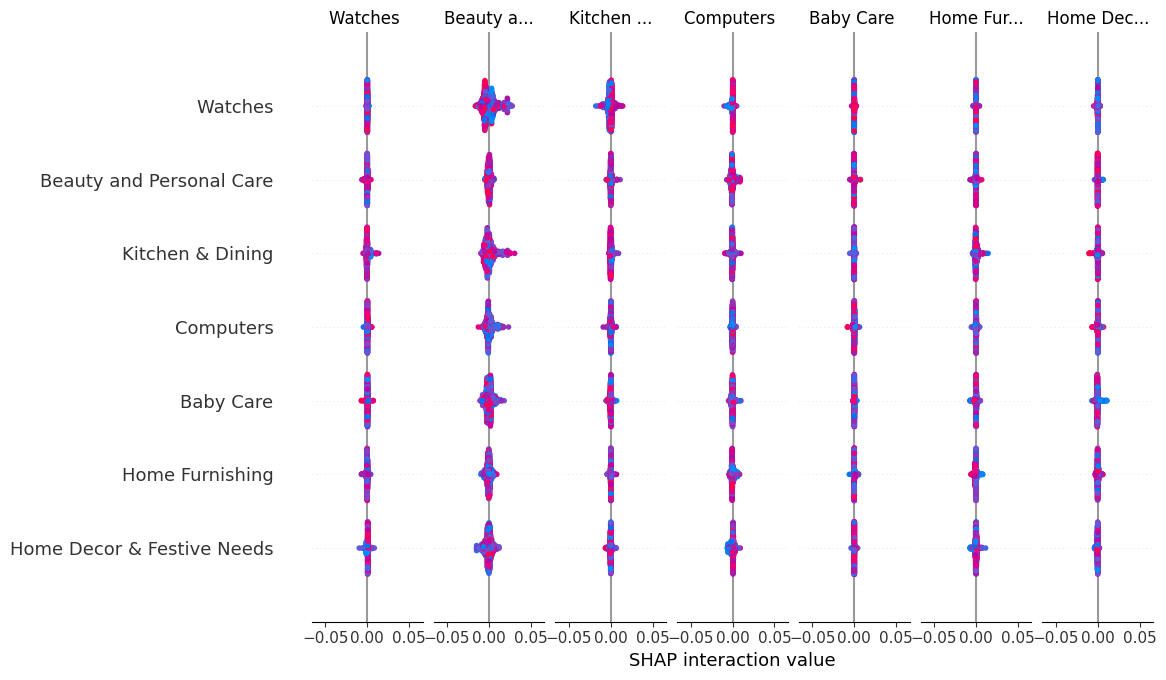

In [ ]:
# Récupérer les vrais noms des features
feature_names = label_encoder.classes_
# shap.summary_plot(shap_values, X_train_m, feature_names=feature_names)
shap.summary_plot(shap_values, X_train_m, feature_names=feature_names, plot_type="dot")

#### **Features importances locale**

In [ ]:
# On choisie un échantillon pour expliquer sa prédiction
sample_index = 0  # l'indice 0 pour expliquer la première prédiction
sample = X_train[sample_index].reshape(1, -1)

# Calcul des valeurs SHAP pour l'échantillon
shap_values_local = explainer.shap_values(sample)

# Visualisation de l'importance locale des features pour cet échantillon
shap.initjs()

# Pour un modèle multi-classe, par exemple pour la première classe
shap.plots.force(explainer.expected_value[0]
                 , shap_values_local[0, :, 0]
                 , sample)


In [ ]:
# Convertir les embeddings en df
# df_embeddings = pd.DataFrame(embeddings_modernbert)
df = embeddings_modernbert.to_pandas()
df.head()

### **Synthèse**

In [ ]:
# Création d'un DF
df_ARI_results = pd.DataFrame(ARI_results, columns=["Modèles", "Reduction", "ARI"])
df_ARI_results['ARI'] = df_ARI_results['ARI'].astype(float)

In [ ]:
# Visualisation
plt.figure(figsize=(6, 6))
fig = px.bar(
    df_ARI_results,
    x="Modèles",
    y="ARI",
    color="Reduction",
    barmode="group",
    title="Le score de ARI par modèles et technique de réduction de dimension"
)

# Personnalisation de l'affichage
fig.update_layout(
    xaxis_title="Modèles",
    yaxis_title="ARI",
    legend_title_text="Dimension Reduction",
    xaxis_tickangle=-45
)

# Affichage
fig.show();

<Figure size 600x600 with 0 Axes>